In [1]:
import numpy as np
import scipy.stats
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

### I/O

In [2]:
FIGURE_SAVEPATH = "../../../figures/"
TYPE1_ERROR_SAVEPATH = "../../../output/type1_errors/"
SAVELABEL = "linear_nonneg_rct"

SAVE = False

### Formatting

In [3]:
method_cmap = {("Chiseling", 0): "#FF590D",
               ("Chiseling", 1): "#2032DA",
               "DataSplittingStrategy": "#FFBB00",
               "SimulDataSplittingStrategy": "#69C1B9",
               "OracleStrategy": "#000000",
               "OracleSimulStrategy": "#6A6A6A",
               "TTestStrategy": "#E70202"}

method_pretty_name_map = {("Chiseling", 0): "Chiseling (Single)",
                          ("Chiseling", 1): "Chiseling (Multiple)",
                          "DataSplittingStrategy": "Data Splitting",
                          "SimulDataSplittingStrategy": "Simul. Data Splitting",
                          "OracleStrategy": "Oracle",
                          "OracleSimulStrategy": "Simul. Oracle",
                          "TTestStrategy": r"$t$-test"}

n_space_cmap = {500: "#FFBB00",
                1500: "#69C1B9",
                4000: "#2032DA"}

LINEWIDTH = 2
DASH_LINESTYLE = "--"
METHOD_LEGEND_COLOR = "#787E93"

MARKERSIZE = 0
LABEL_FONTSIZE = 15
TITLE_FONTSIZE = 16
LEGEND_FONTSIZE = 14
TICK_FONTSIZE = 14
HIDESPINES = True

### Preprocessing

In [4]:
task_array_path = "../../task_arrays/linear_nonneg_rct.tasks.tsv"
res_path = "../../../output/linear_nonneg_rct/linear_nonneg_rct.combined.tsv"

In [5]:
task_df = pd.read_csv(task_array_path, sep="\t", index_col=None)
res_df = pd.read_csv(res_path, sep="\t", index_col=None)
# Merge task meta and results
res_df = res_df.merge(task_df, how="left", on="task_id")

In [6]:
# Aggregate results
setting_identifiers = ["task_label", "q", "strategy"]
agg_res_df = res_df.groupby(setting_identifiers, dropna=False)[["rejected", "subgroup_utility", "region_mass"]].agg(["mean", "var", "count"])
agg_res_df.columns = ["_".join(c) for c in agg_res_df.columns.to_flat_index()]
agg_res_df = agg_res_df.reset_index()
agg_res_df["rejected_se"] = np.sqrt(agg_res_df.rejected_var / agg_res_df.rejected_count)
agg_res_df["subgroup_utility_se"] = np.sqrt(agg_res_df.subgroup_utility_var / agg_res_df.subgroup_utility_count)
agg_res_df["region_mass_se"] = np.sqrt(agg_res_df.region_mass_var / agg_res_df.region_mass_count)
agg_res_df = agg_res_df.loc[:,setting_identifiers + ["rejected_mean", "rejected_var", "rejected_se",
                                                     "subgroup_utility_mean", "subgroup_utility_var",
                                                     "subgroup_utility_se", "region_mass_mean",
                                                     "region_mass_var", "region_mass_se"]]

### Standardize by optimal region utilities

The way these simulations are setup, all optimal subgroup utilities are $0.1$.

In [7]:
agg_res_df["opt_utility"] = 0.1
agg_res_df["norm_subgroup_utility_mean"] = (agg_res_df["subgroup_utility_mean"] /
                                            agg_res_df["opt_utility"])

# Also normalize the subgroup utility variances (as stddevs)
agg_res_df["norm_subgroup_utility_std"] = (np.sqrt(agg_res_df["subgroup_utility_var"]) /
                                           agg_res_df["opt_utility"])

### Settings

In [8]:
strategy_space = ["Chiseling", "TTestStrategy", "OracleStrategy", "OracleSimulStrategy"]

oracle_strategies = ["OracleStrategy", "OracleSimulStrategy"]

### Inspections

Nonnegative effects

In [9]:
sub_res_df = agg_res_df[agg_res_df.task_label == "nonneg"]

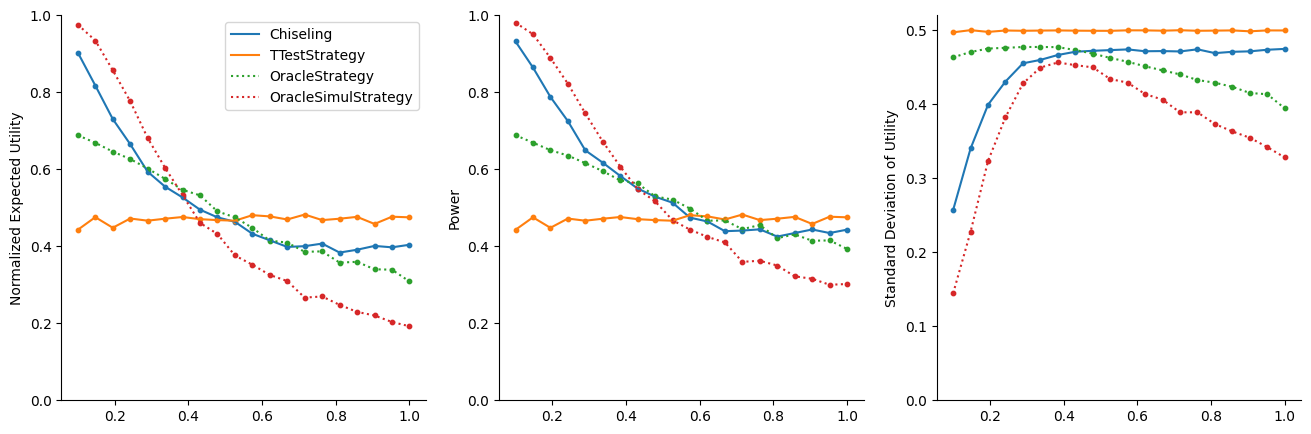

In [10]:
fig, ax = plt.subplots(1,3,figsize=(16,5))

for strategy in strategy_space:
    sub_sub_res_df = sub_res_df[sub_res_df.strategy == strategy].sort_values("q")
    # Get linestyle based on if method is oracle
    if strategy in oracle_strategies:
        ls = ":"
    else:
        ls = "-"
    # Expected utility
    ax[0].plot(sub_sub_res_df.q, sub_sub_res_df.norm_subgroup_utility_mean,
               label=strategy, linestyle=ls)
    last_color = ax[0].get_lines()[-1].get_color()
    ax[0].scatter(sub_sub_res_df.q, sub_sub_res_df.norm_subgroup_utility_mean,
                  color=last_color, s=10)
    # Power
    ax[1].plot(sub_sub_res_df.q, sub_sub_res_df.rejected_mean,
               label=strategy, linestyle=ls)
    last_color = ax[0].get_lines()[-1].get_color()
    ax[1].scatter(sub_sub_res_df.q, sub_sub_res_df.rejected_mean,
                  color=last_color, s=10)
    # Stddev of utility (normalized)
    ax[2].plot(sub_sub_res_df.q, sub_sub_res_df.norm_subgroup_utility_std,
               label=strategy, linestyle=ls)
    last_color = ax[0].get_lines()[-1].get_color()
    ax[2].scatter(sub_sub_res_df.q, sub_sub_res_df.norm_subgroup_utility_std,
                  color=last_color, s=10)

for i in range(3):
    ax[i].spines[['right', 'top']].set_visible(False)

for i in range(2):
    ax[i].set_ylim(0,1)
ax[2].set_ylim(0,0.5 + 0.02)

ax[0].set_ylabel("Normalized Expected Utility")
ax[1].set_ylabel("Power")
ax[2].set_ylabel("Standard Deviation of Utility")

ax[0].legend()

plt.show()

Small negative effects

In [11]:
sub_res_df = agg_res_df[agg_res_df.task_label == "smallneg"]

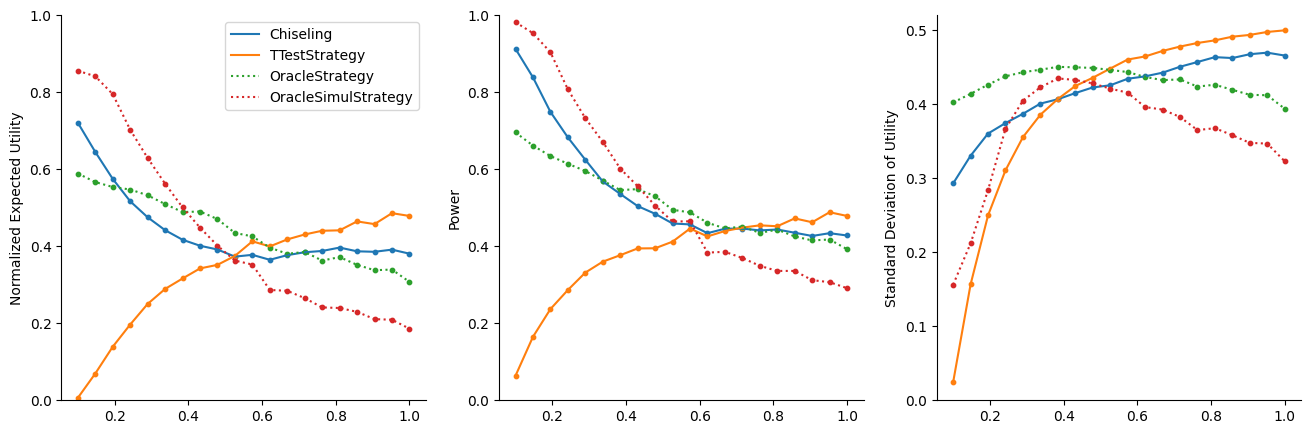

In [12]:
fig, ax = plt.subplots(1,3,figsize=(16,5))

for strategy in strategy_space:
    sub_sub_res_df = sub_res_df[sub_res_df.strategy == strategy].sort_values("q")
    # Get linestyle based on if method is oracle
    if strategy in oracle_strategies:
        ls = ":"
    else:
        ls = "-"
    # Expected utility
    ax[0].plot(sub_sub_res_df.q, sub_sub_res_df.norm_subgroup_utility_mean,
               label=strategy, linestyle=ls)
    last_color = ax[0].get_lines()[-1].get_color()
    ax[0].scatter(sub_sub_res_df.q, sub_sub_res_df.norm_subgroup_utility_mean,
                  color=last_color, s=10)
    # Power
    ax[1].plot(sub_sub_res_df.q, sub_sub_res_df.rejected_mean,
               label=strategy, linestyle=ls)
    last_color = ax[0].get_lines()[-1].get_color()
    ax[1].scatter(sub_sub_res_df.q, sub_sub_res_df.rejected_mean,
                  color=last_color, s=10)
    # Stddev of utility (normalized)
    ax[2].plot(sub_sub_res_df.q, sub_sub_res_df.norm_subgroup_utility_std,
               label=strategy, linestyle=ls)
    last_color = ax[0].get_lines()[-1].get_color()
    ax[2].scatter(sub_sub_res_df.q, sub_sub_res_df.norm_subgroup_utility_std,
                  color=last_color, s=10)

for i in range(3):
    ax[i].spines[['right', 'top']].set_visible(False)

for i in range(2):
    ax[i].set_ylim(0,1)
ax[2].set_ylim(0,0.5 + 0.02)

ax[0].set_ylabel("Normalized Expected Utility")
ax[1].set_ylabel("Power")
ax[2].set_ylabel("Standard Deviation of Utility")

ax[0].legend()

plt.show()

### Visualizations

Expected utility

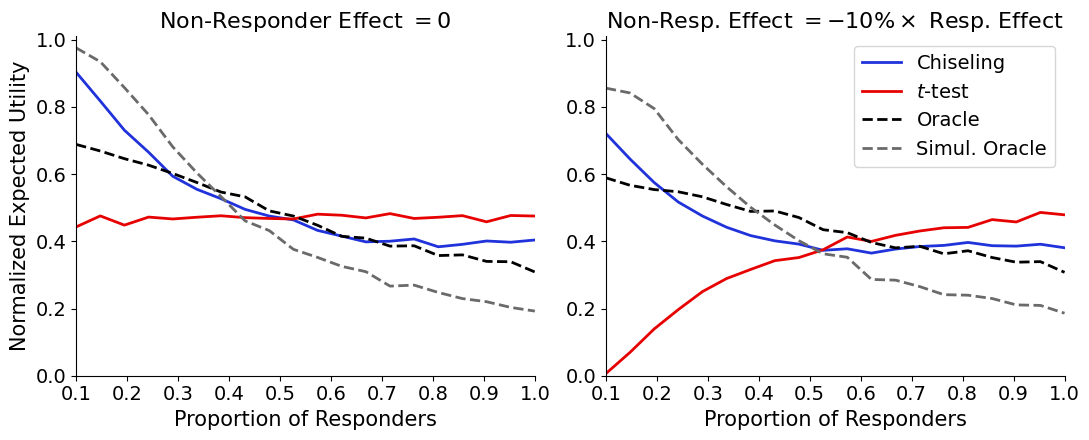

In [13]:
fig, ax = plt.subplots(1,2,figsize=(11,4.5))

VIZ_PROPERTY = "norm_subgroup_utility_mean"
YLABEL = "Normalized Expected Utility"
PLOT_SAVELABEL = "utility"

# Initialize panel coordinates
PANEL_COUNTER = 0
AX0 = PANEL_COUNTER

for task_label in ["nonneg", "smallneg"]:
    sub_res_df = agg_res_df
    sub_res_df = sub_res_df[sub_res_df.task_label == task_label]
    # Chiseling
    color = method_cmap[("Chiseling", 1)]
    method_pretty_name = "Chiseling"
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "Chiseling"]
    sub_sub_res_df = sub_sub_res_df.sort_values("q")
    ax[AX0].plot(sub_sub_res_df.q, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                 label=method_pretty_name, color=color, linewidth=LINEWIDTH)
    ax[AX0].scatter(sub_sub_res_df.q, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                    color=color, s=MARKERSIZE)
    # T-test
    color = method_cmap["TTestStrategy"]
    method_pretty_name = method_pretty_name_map["TTestStrategy"]
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "TTestStrategy"]
    sub_sub_res_df = sub_sub_res_df.sort_values("q")
    ax[AX0].plot(sub_sub_res_df.q, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                 label=method_pretty_name, color=color, linewidth=LINEWIDTH)
    ax[AX0].scatter(sub_sub_res_df.q, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                    color=color, s=MARKERSIZE)
    # Oracle
    color = method_cmap["OracleStrategy"]
    method_pretty_name = method_pretty_name_map["OracleStrategy"]
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "OracleStrategy"]
    sub_sub_res_df = sub_sub_res_df.sort_values("q")
    ax[AX0].plot(sub_sub_res_df.q, sub_sub_res_df.loc[:,VIZ_PROPERTY], linestyle=DASH_LINESTYLE,
                 label=method_pretty_name, color=color, linewidth=LINEWIDTH)
    ax[AX0].scatter(sub_sub_res_df.q, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                    color=color, s=MARKERSIZE)
    # Oracle simultaneous
    color = method_cmap["OracleSimulStrategy"]
    method_pretty_name = method_pretty_name_map["OracleSimulStrategy"]
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "OracleSimulStrategy"]
    sub_sub_res_df = sub_sub_res_df.sort_values("q")
    ax[AX0].plot(sub_sub_res_df.q, sub_sub_res_df.loc[:,VIZ_PROPERTY], linestyle=DASH_LINESTYLE,
                 label=method_pretty_name, color=color, linewidth=LINEWIDTH)
    ax[AX0].scatter(sub_sub_res_df.q, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                    color=color, s=MARKERSIZE)
    # Set x-labels
    ax[AX0].set_xlabel("Proportion of Responders", fontsize=LABEL_FONTSIZE)
    # Set ylim
    ax[AX0].set_ylim(0,1+0.01)
    # Set xlim
    ax[AX0].set_xlim(0.1,1)
    ax[AX0].xaxis.set_major_locator(mticker.MultipleLocator(0.1))
    # Tick fontsize
    ax[AX0].tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)
    # Hide spines
    if HIDESPINES:
        ax[AX0].spines[['right', 'top']].set_visible(False)
    # Increment panel coordinates
    PANEL_COUNTER += 1
    AX0 = PANEL_COUNTER

# Global formatting
ax[0].set_ylabel(YLABEL, fontsize=LABEL_FONTSIZE)
ax[-1].legend(fontsize=LEGEND_FONTSIZE)

ax[0].set_title(r"Non-Responder Effect $= 0$", fontsize=TITLE_FONTSIZE)
ax[1].set_title(r"Non-Resp. Effect $= -10\% \times$ Resp. Effect", fontsize=TITLE_FONTSIZE)

plt.tight_layout()

# Save
if SAVE:
    plt.savefig(FIGURE_SAVEPATH + "{}.{}.pdf".format(SAVELABEL, PLOT_SAVELABEL), bbox_inches="tight", dpi=300)

plt.show()

Power

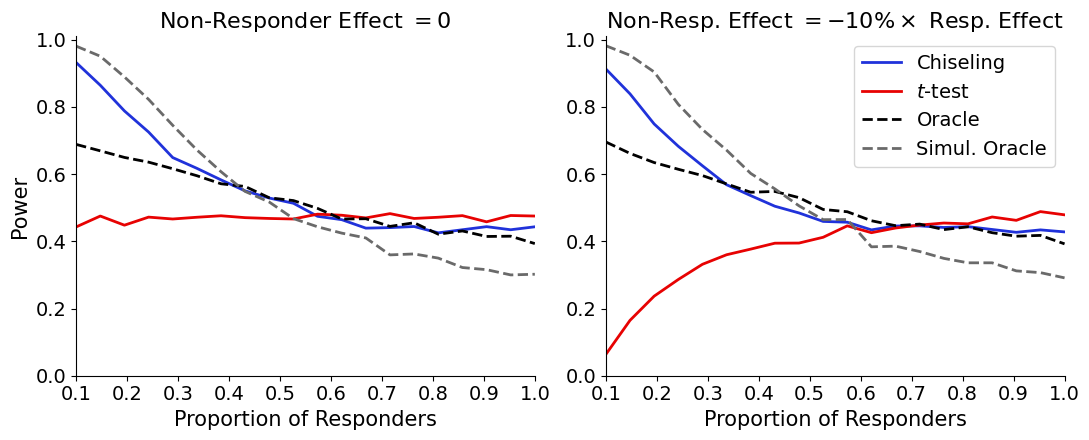

In [14]:
fig, ax = plt.subplots(1,2,figsize=(11,4.5))

VIZ_PROPERTY = "rejected_mean"
YLABEL = "Power"
PLOT_SAVELABEL = "power"

# Initialize panel coordinates
PANEL_COUNTER = 0
AX0 = PANEL_COUNTER

for task_label in ["nonneg", "smallneg"]:
    sub_res_df = agg_res_df
    sub_res_df = sub_res_df[sub_res_df.task_label == task_label]
    # Chiseling
    color = method_cmap[("Chiseling", 1)]
    method_pretty_name = "Chiseling"
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "Chiseling"]
    sub_sub_res_df = sub_sub_res_df.sort_values("q")
    ax[AX0].plot(sub_sub_res_df.q, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                 label=method_pretty_name, color=color, linewidth=LINEWIDTH)
    ax[AX0].scatter(sub_sub_res_df.q, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                    color=color, s=MARKERSIZE)
    # T-test
    color = method_cmap["TTestStrategy"]
    method_pretty_name = method_pretty_name_map["TTestStrategy"]
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "TTestStrategy"]
    sub_sub_res_df = sub_sub_res_df.sort_values("q")
    ax[AX0].plot(sub_sub_res_df.q, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                 label=method_pretty_name, color=color, linewidth=LINEWIDTH)
    ax[AX0].scatter(sub_sub_res_df.q, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                    color=color, s=MARKERSIZE)
    # Oracle
    color = method_cmap["OracleStrategy"]
    method_pretty_name = method_pretty_name_map["OracleStrategy"]
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "OracleStrategy"]
    sub_sub_res_df = sub_sub_res_df.sort_values("q")
    ax[AX0].plot(sub_sub_res_df.q, sub_sub_res_df.loc[:,VIZ_PROPERTY], linestyle=DASH_LINESTYLE,
                 label=method_pretty_name, color=color, linewidth=LINEWIDTH)
    ax[AX0].scatter(sub_sub_res_df.q, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                    color=color, s=MARKERSIZE)
    # Oracle simultaneous
    color = method_cmap["OracleSimulStrategy"]
    method_pretty_name = method_pretty_name_map["OracleSimulStrategy"]
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "OracleSimulStrategy"]
    sub_sub_res_df = sub_sub_res_df.sort_values("q")
    ax[AX0].plot(sub_sub_res_df.q, sub_sub_res_df.loc[:,VIZ_PROPERTY], linestyle=DASH_LINESTYLE,
                 label=method_pretty_name, color=color, linewidth=LINEWIDTH)
    ax[AX0].scatter(sub_sub_res_df.q, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                    color=color, s=MARKERSIZE)
    # Set x-labels
    ax[AX0].set_xlabel("Proportion of Responders", fontsize=LABEL_FONTSIZE)
    # Set ylim
    ax[AX0].set_ylim(0,1+0.01)
    # Set xlim
    ax[AX0].set_xlim(0.1,1)
    ax[AX0].xaxis.set_major_locator(mticker.MultipleLocator(0.1))
    # Tick fontsize
    ax[AX0].tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)
    # Hide spines
    if HIDESPINES:
        ax[AX0].spines[['right', 'top']].set_visible(False)
    # Increment panel coordinates
    PANEL_COUNTER += 1
    AX0 = PANEL_COUNTER

# Global formatting
ax[0].set_ylabel(YLABEL, fontsize=LABEL_FONTSIZE)
ax[-1].legend(fontsize=LEGEND_FONTSIZE)

ax[0].set_title(r"Non-Responder Effect $= 0$", fontsize=TITLE_FONTSIZE)
ax[1].set_title(r"Non-Resp. Effect $= -10\% \times$ Resp. Effect", fontsize=TITLE_FONTSIZE)

plt.tight_layout()

# Save
if SAVE:
    plt.savefig(FIGURE_SAVEPATH + "{}.{}.pdf".format(SAVELABEL, PLOT_SAVELABEL), bbox_inches="tight", dpi=300)

plt.show()

### Type I error

In [15]:
# Add error column
res_df["error"] = res_df.rejected & (res_df.subgroup_utility <= 0)

In [16]:
# Aggregate
error_df = res_df.groupby(setting_identifiers, dropna=False)[["error"]].agg(["mean", "var", "count"])
error_df.columns = ["_".join(c) for c in error_df.columns.to_flat_index()]
error_df = error_df.reset_index()
error_df["error_se"] = np.sqrt(error_df.error_var / error_df.error_count)

error_df = error_df.loc[:,setting_identifiers + ["error_mean", "error_se"]]

In [17]:
# Subset to only chiseling methods
error_df = error_df[error_df.strategy == "Chiseling"]

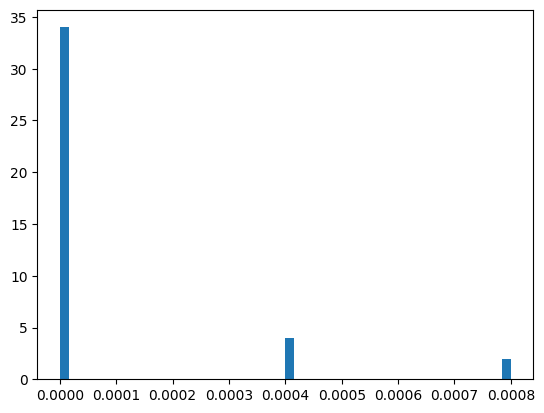

Min = 0.0 / Max = 0.0008


In [18]:
# Visualize here as a sanity check
plt.hist(error_df.error_mean.values, bins=50)
plt.show()

print("Min = {} / Max = {}".format(error_df.error_mean.min(), error_df.error_mean.max()))

In [19]:
# Save
if SAVE:
    error_df.to_csv(TYPE1_ERROR_SAVEPATH + "{}.{}.tsv".format(SAVELABEL, "t1e"), sep="\t", index=False)